# Tutorial 9 - Microrheology

Welcome to the microrheology tutorial !
In this notebook, we'll infer the microrheolt of PEO on the structure function obtained with DDM.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the basic tutorial 1 to 6.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `APPLICATION_DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686).

Your main directory tree should resemble the following:
```
.
├── APPLICATION_DATASET
│   └── ...
├── MICRORHEOLOGY_TUTORIALS
│   └── Tutorial-Microrheology
│   └── ...
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 330 nm, Invitrogen) dispersed in a aqueous solution solution of poly(ethylene oxide) (PEO, $M_w$ = 900 kDa, Sigma-Aldrich),
prepared at a mass fraction c = 2.1% by gentle stirring
at $T = 40^{\circ}\mathrm{C}$ to fully dissolve the polymer. 
The sample was prepared at a volume fraction $\phi=7.5 \times 10^{-7}$ and loaded into a 0.2 $\times$ 2 $\times$ 50 mm glass capillary (Vitrocom).
The experiments were performed at $T \simeq 20^{\circ}\mathrm{C}$.

The videos were acquired at 100 fps, using a Nikon Eclipse Ti-E inverted microscope equipped with a Mako-U130 (Allied
Vision Technologies) CMOS camera using a 20$\times$, NA 0.5 microscope objective, yielding an efective pixel size $\delta _\mathrm{px} = 0.24 ~\mathrm{\mu m}$


### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:

import gc
import os
import lmfit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText



def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

import fastddm as fddm
from fastddm.fit import fit

# for microrheology
from scipy.special import gamma
from scipy.optimize import minimize

## Compute the image structure function and the azimuthal average

The process here mirrors the one outlined in [tutorial2](../Tutorial_2-Melt/tutorial2.ipynb).
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [2]:
main_dir = '../APPLICATION_DATASET/MICRORHEOLOGY/11_PEO900kDA_2_2WT_300nm_7_5E-4_20X_0_5NA_125k_FPS100/Images'

In [3]:
# set parameters
pixel_size = 4.5/20    # micrometer/pixel
frame_rate = 100.0     # frames/s

In [4]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
# CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

In [5]:
# compute image structure function and azimuthal average

# read image sequence
img_seq = fddm.read_images([os.path.join(main_dir, f'Image{n:08}.tif') for n in range(125000)])

# compute image structure function
dqt = fddm.ddm(img_seq, range(1,len(img_seq)), core=CORE, mode=MODE)
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate)

# compute azimuthal average
# we go to high q, it's easier to just create a list of bin edges using delta_q as the unit
bins = int(np.sqrt(2) * (dqt.shape[-1] - 1))
bin_edges = np.linspace(0, bins*dqt.kx[1], bins+1)
# mask out the central cross
ccm = fddm.mask.central_cross_mask(dqt.shape[1:])
# compute
aa = fddm.azimuthal_average(dqt, bins=bin_edges, mask=ccm)

## Estimate noise factor

In [6]:

Bq, _ = fddm.noise_est.estimate_camera_noise(aa,
                                                  mode="polyfit",
                                                  num_points=5)

Aq = 2 * aa.var - Bq

## Resample azimuthal average

Just cut in half.

In [7]:
# remove the first lag
new_tau = fddm.lags.logspace_int(len(aa.tau), num=15*int(np.log10(len(aa.tau))), endpoint=True)[1:] * aa.tau[0]
aa_res = aa.resample(new_tau)

In [8]:
aa.save('./az_avg.aa.ddm')
aa_res.save('./az_avg_res.aa.ddm')

## Show estimated mean square displacement

Text(0, 0.5, '$f(q, \\Delta t)$')

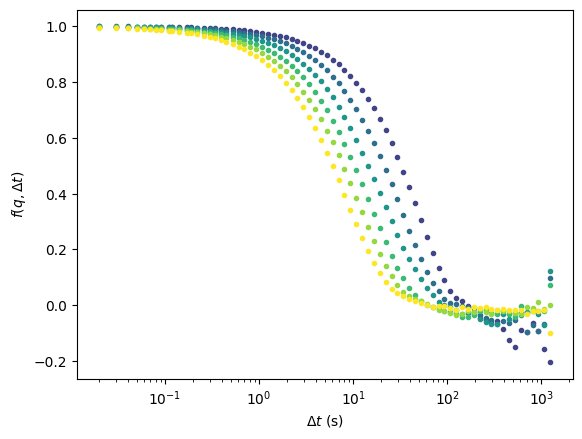

In [9]:
# show estimated intermediate scattering functions
fig = plt.figure()
ax = fig.add_subplot()

krange=range(17, 45, 5)
f = 1 - (aa_res.data[krange] - Bq[krange, np.newaxis])/(Aq[krange, np.newaxis])

cspace = color_space(len(krange))
for n, _ in enumerate(krange):
    ax.plot(aa_res.tau, f[n], '.', color=cspace[n])

#ax.plot([0.1, 2], [0.1, 2], 'k--')
ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$f(q, \Delta t)$')
#ax.set_xlim(xmax=4)

/tmp/ipykernel_2013402/1009825573.py:7: RuntimeWarning: invalid value encountered in log
  msd = -4/aa_res.k[krange, np.newaxis]**2 * np.log(f)


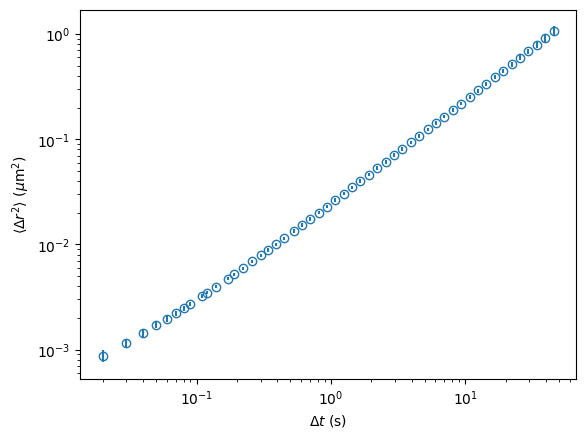

In [10]:
# show estimated mean square displacement
fig = plt.figure()
ax = fig.add_subplot()

krange=range(17, 45)
f = 1 - (aa_res.data[krange] - Bq[krange, np.newaxis])/(Aq[krange, np.newaxis])
msd = -4/aa_res.k[krange, np.newaxis]**2 * np.log(f)
mu = np.mean(msd, axis=0)
err = np.std(msd, axis=0, ddof=1)
ax.errorbar(x=aa_res.tau, y=mu, yerr=err, fmt='o', markerfacecolor='none')

#ax.plot([0.1, 2], [0.1, 2], 'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ ($\mu$m$^2$)');
#ax.set_xlim(xmax=4)

## Microrheology

The viscoelastic modulus is related to the tracer particles mean square displacement via

$$G^*(\omega) = \frac{d k_B T}{3 \pi a \mathrm{i} \omega \langle \Delta r^2 (\mathrm{i} \omega) \rangle}$$

where $d$ is the number of dimensions probed by the technique ($d=2$ for DDM) and $a$ is the hydrodynamic radius. To avoid the Fourier transform, a more numerically robust method is to locally expand the mean square displacement around $\omega = 1/\Delta t$ to a power law having exponent

$$\alpha(\omega) = \frac{\mathrm{d}\ln \langle \Delta r^2 (\Delta t) \rangle}{\mathrm{d} \ln \Delta t}\lvert_{\Delta t = 1/\omega} .$$

The viscoelastic modulus becomes then

$$G^*(\omega) = \frac{d k_B T}{3 \pi a \langle \Delta r^2 (\omega) \rangle \Gamma(1+\alpha(\omega))} ,$$
where $\Gamma$ is the Gamma function.

The elastic (storage) and viscous (loss) moduli are then related to the viscoelastic modulus via

$$G'(\omega) = G^*(\omega) \cos\left( \frac{\pi \alpha(\omega)}{2} \right)$$

$$G''(\omega) = G^*(\omega) \sin\left( \frac{\pi \alpha(\omega)}{2} \right)$$

and the complex viscosity reads

$$\eta^*(\omega) = \frac{G^*(\omega)}{\mathrm{i} \omega}$$

$$\lvert \eta^*(\omega) \rvert = \sqrt{\frac{[G'(\omega)]^2 + [G''(\omega)]^2}{\omega^2}}$$

In [11]:
# compute omega
omega = 1/aa_res.tau

# compute again msd
krange = range(17,45)
f = 1 - (aa_res.data[krange] - Bq[krange, np.newaxis])/(Aq[krange, np.newaxis])
msd = -4/aa_res.k[krange, np.newaxis]**2 * np.log(f)
avg_msd = np.mean(msd, axis=0)
std_msd = np.std(msd, axis=0, ddof=1)

# compute alpha
alpha = np.gradient(np.log(avg_msd), np.log(aa_res.tau), edge_order=2)

# compute G*
kT = 1.38e-23 * 300
a = 185e-9

G_star = 2/3 * kT / (np.pi * a * avg_msd * 1e-12 * gamma(1 + alpha))

# compute G' and G''
G_prime = G_star * np.cos(np.pi * alpha / 2)
G_secondp = G_star * np.sin(np.pi * alpha / 2)

/tmp/ipykernel_2013402/824840061.py:7: RuntimeWarning: invalid value encountered in log
  msd = -4/aa_res.k[krange, np.newaxis]**2 * np.log(f)


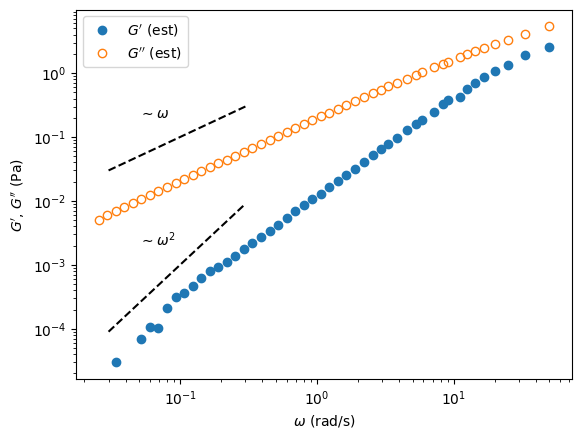

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(omega, G_prime, 'o', label=r"$G'$ (est)")
ax.plot(omega, G_secondp, 'o', markerfacecolor='none', label=r"$G''$ (est)")

# plot also reference lines
x=np.array([3e-2, 3e-1])
ax.plot(x, x, 'k--')
ax.annotate(r'$\sim \omega$', xy=(5e-2, 5e-2), xytext=(5e-2, 2e-1))
ax.plot(x, 1e-1*x**2, 'k--')
ax.annotate(r'$\sim \omega^2$', xy=(5e-2, 3e-4), xytext=(5e-2, 2e-3))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$ (rad/s)')
ax.set_ylabel(r"$G'$, $G''$ (Pa)")
ax.legend()

fig.savefig('microrheology_standard.pdf', dpi=600)

## Adaptive algorithm

These are the steps

1. Choose a rasonable range of $q$ vectors
2. Estimate for each $q$ the initial parameters $A(q)$ and $B(q)$
3. Calculate the mean square displacement for each $q$ in the interval using the formula
   $$\langle \Delta r^2 (\Delta t \lvert q) \rangle = -\frac{4}{q^2} \ln\left[ 1 - \frac{D(q,\Delta t) - B(q)}{A(q)} \right]$$
4. For each $\Delta t$, determine the subset of $q$ vectors such that $\langle \Delta r^2 (\Delta t \lvert q) \rangle < q^{-2}$. These values do not have completely lost track of the correlation and can be meaningfully inverted
5. Calculate the average mean square displacement
   $$\langle \Delta r^2 (\Delta t) \rangle = \frac{1}{N_q(\Delta t)} \sum_q \langle \Delta r^2 (\Delta t \lvert q) \rangle , $$
   where $N_q(\Delta t)$ is the number of $q$ vectors in the subset
6. Calculate the time-dependent dispersion
   $$\sigma^2 (\Delta t) = \frac{1}{N_q(\Delta t) - 1} \sum_q \ln^2 \frac{\langle \Delta r^2 (\Delta t \lvert q) \rangle}{\langle \Delta r^2 (\Delta t) \rangle}$$
   and the total dispersion
   $$\sigma^2 = \sum_{\Delta t} \sigma^2 (\Delta t)$$
7. Minimize $\sigma^2$

In [13]:
def dispersion(k, isf):
    e = np.exp(1)
    q = k[(isf>e**(-1/4)) & (isf < 1)]
    f = isf[(isf>e**(-1/4)) & (isf < 1)]
    N = len(f)
    if N < 5:
        return np.nan, np.nan, np.nan, False
    d = -4 / q**2 * np.log(f)
    mu = np.mean(d)
    std = np.std(d, ddof=1)
    sigma2 = np.sum(np.log(d/mu)**2) / (N-1)
    return sigma2, mu, std, True

def sigma2(x, q, data, Aq_star, Bq_star, avg_msd, std_msd, success):
    # unpack x
    beta_A = x[:len(x)//2]
    beta_B = x[len(x)//2:]
    
    # compute actual Aq and Bq
    Aq = beta_A * Aq_star
    Bq = beta_B * Bq_star
    
    # compute intermediate scattering function
    f = 1 - (data - Bq[:, np.newaxis]) / Aq[:, np.newaxis]
    
    # calculate the dispersion
    sigma2_tmp = np.zeros(data.shape[-1])
    for dt in range(len(sigma2_tmp)):
        sigma2_tmp[dt], avg_msd[dt], std_msd[dt], success[dt] = dispersion(q, f[:,dt])
    
    # return the total dispersion
    sigma2 = np.nanmean(sigma2_tmp)
    return sigma2

In [14]:
# choose a k range
krange = range(15,45)

# select the data
data = aa_res.data[krange]
q = aa_res.k[krange]

# get first estimate of A and B
Aq0 = 2 * aa_res.power_spec[krange] - Bq[krange]
Bq0 = Bq[krange]

# initialize solution vector
x0 = np.ones(2 * len(krange))

# compute
avg_msd_opt = np.zeros(data.shape[-1])
std_msd_opt = np.zeros(data.shape[-1])
success_opt = np.zeros(data.shape[-1]).astype(bool)
result = minimize(sigma2, x0=x0, args=(q, data, Aq0, Bq0, avg_msd_opt, std_msd_opt, success_opt), method='Nelder-Mead', tol=1e-2)

Text(0, 0.5, '$f(q, \\Delta t)$')

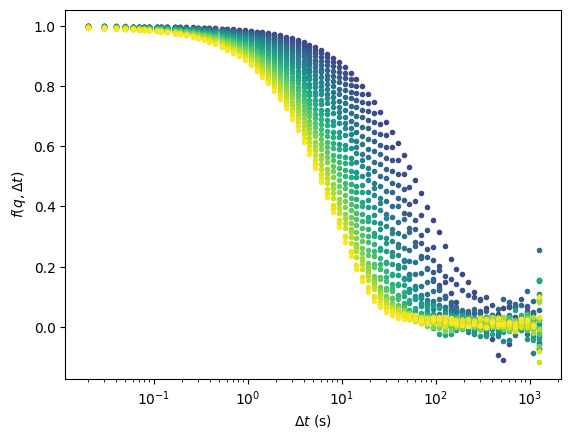

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

Aq = Aq0 * result.x[:len(result.x)//2]
Bq = Bq0 * result.x[len(result.x)//2:]
f = 1 - (data - Bq[:, np.newaxis])/(Aq[:, np.newaxis])

cspace = color_space(len(krange))
for n, _ in enumerate(krange):
    if success_opt[n]:
        ax.plot(aa_res.tau, f[n], '.', color=cspace[n])

#ax.plot([0.1, 2], [0.1, 2], 'k--')
ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$f(q, \Delta t)$')
#ax.set_xlim(xmax=4)

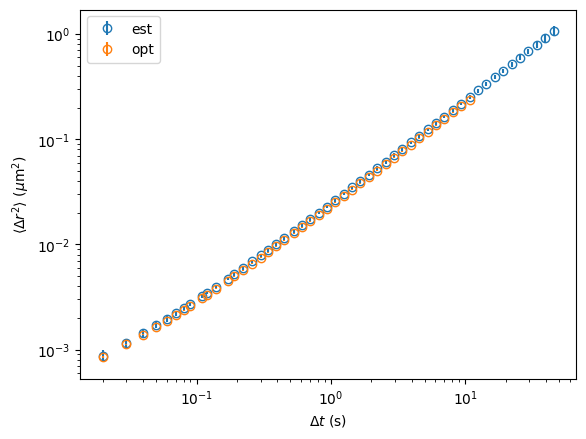

In [16]:
fig = plt.figure()
ax = fig.add_subplot()

ax.errorbar(x=aa_res.tau, y=avg_msd, yerr=std_msd, fmt='o', markerfacecolor='none', label='est')

ax.errorbar(x=aa_res.tau, y=avg_msd_opt, yerr=std_msd_opt, fmt='o', markerfacecolor='none', label='opt')


#ax.plot([0.1, 2], [0.1, 2], 'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ ($\mu$m$^2$)')
ax.legend()

fig.savefig('msd_cfr.pdf', dpi=600)

## Microrheology with optimized data

In [17]:
# compute omega
omega = 1/aa_res.tau

# compute alpha
alpha_opt = np.gradient(np.log(avg_msd_opt), np.log(aa_res.tau), edge_order=2)

# compute G*
kT = 1.38e-23 * 300
a = 185e-9

G_star_opt = 2/3 * kT / (np.pi * a * avg_msd_opt * 1e-12 * gamma(1 + alpha_opt))

# compute G' and G''
G_prime_opt = G_star_opt * np.cos(np.pi * alpha_opt / 2)
G_secondp_opt = G_star_opt * np.sin(np.pi * alpha_opt / 2)

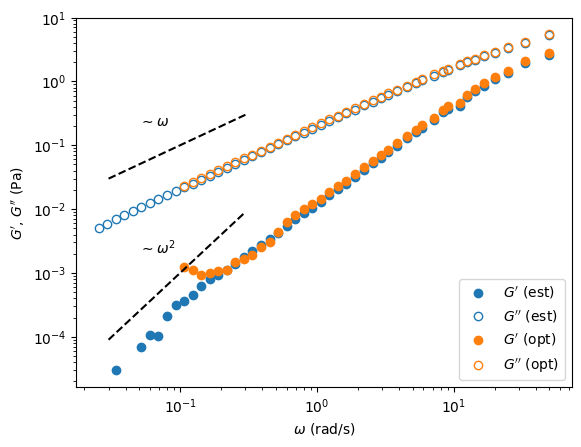

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# estimate
ax.plot(omega, G_prime, 'C0o', label=r"$G'$ (est)")
ax.plot(omega, G_secondp, 'C0o', markerfacecolor='none', label=r"$G''$ (est)")

# optimization
ax.plot(omega, G_prime_opt, 'C1o', label=r"$G'$ (opt)")
ax.plot(omega, G_secondp_opt, 'C1o', markerfacecolor='none', label=r"$G''$ (opt)")

# plot also reference lines
x=np.array([3e-2, 3e-1])
ax.plot(x, x, 'k--')
ax.annotate(r'$\sim \omega$', xy=(5e-2, 5e-2), xytext=(5e-2, 2e-1))
ax.plot(x, 1e-1*x**2, 'k--')
ax.annotate(r'$\sim \omega^2$', xy=(5e-2, 3e-4), xytext=(5e-2, 2e-3))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$ (rad/s)')
ax.set_ylabel(r"$G'$, $G''$ (Pa)")
ax.legend()

fig.savefig('microrheology_cfr_opt.pdf', dpi=600)

## Load rheology data

In [19]:
import pandas as pd
Gp_dls_df = pd.read_csv('Gp_dls.csv', names=['omega', 'Gp'])
Gsp_dls_df = pd.read_csv('Gsp_dls.csv', names=['omega', 'Gsp'])
G_rheo_df = pd.read_csv('FreqSweep.txt', sep='\t')
visc_dls_df = pd.read_csv('eta_dls.csv', names=['omega', 'viscosity'])
rheo_ss_visc_df = pd.read_csv('eta_steadyshear.csv', names=['gamma_dot', 'viscosity'])

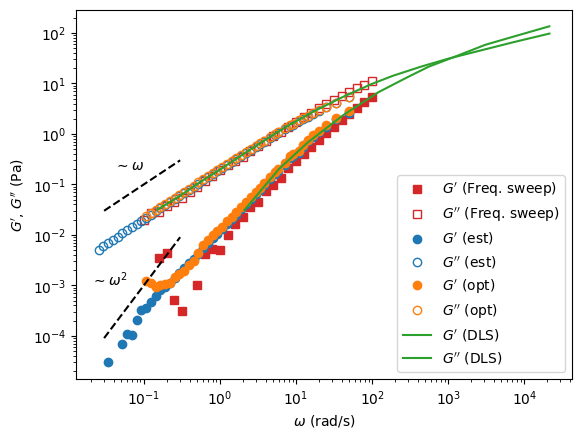

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot frequency sweep data
ax.plot(G_rheo_df['omega'], G_rheo_df['G_prime'], 'C3s', label=r"$G'$ (Freq. sweep)")
ax.plot(G_rheo_df['omega'], G_rheo_df['G_second_prime'], 'C3s', markerfacecolor='none', label=r"$G''$ (Freq. sweep)")

# estimate
ax.plot(omega, G_prime, 'C0o', label=r"$G'$ (est)")
ax.plot(omega, G_secondp, 'C0o', markerfacecolor='none', label=r"$G''$ (est)")

# optimization
ax.plot(omega, G_prime_opt, 'C1o', label=r"$G'$ (opt)")
ax.plot(omega, G_secondp_opt, 'C1o', markerfacecolor='none', label=r"$G''$ (opt)")

# plot also reference lines
x=np.array([3e-2, 3e-1])
ax.plot(x, x, 'k--')
ax.annotate(r'$\sim \omega$', xy=(5e-2, 5e-2), xytext=(4e-2, 2e-1))
ax.plot(x, 1e-1*x**2, 'k--')
ax.annotate(r'$\sim \omega^2$', xy=(5e-2, 3e-4), xytext=(2e-2, 1e-3))

# plot dls data
ax.plot(Gp_dls_df['omega'], Gp_dls_df['Gp'], 'C2-', label=r"$G'$ (DLS)")
ax.plot(Gsp_dls_df['omega'], Gsp_dls_df['Gsp'], 'C2-', label=r"$G''$ (DLS)")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$ (rad/s)')
ax.set_ylabel(r"$G'$, $G''$ (Pa)")
ax.legend()

fig.savefig('microrheology_cfr.pdf', dpi=600)

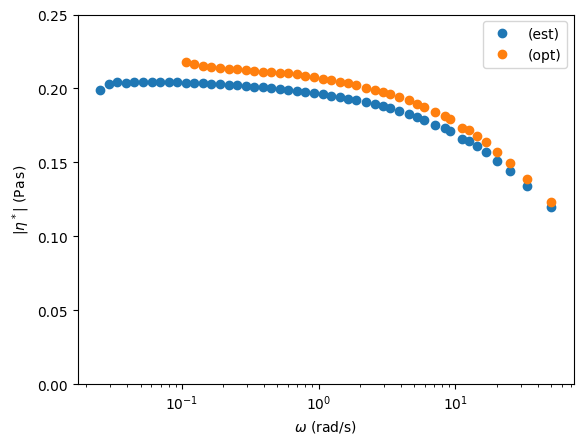

In [21]:
# complex viscosity
eta = G_star / omega
eta_opt = G_star_opt / omega

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# estimate
ax.plot(omega, eta, 'C0o', label="(est)")

# optimization
ax.plot(omega, eta_opt, 'C1o', label="(opt)")

ax.set_xscale('log')
ax.set_xlabel(r'$\omega$ (rad/s)')
ax.set_ylabel(r"$\vert \eta^* \vert$ (Pa$\,$s)")
ax.set_ylim(0, 0.25)
ax.legend()

fig.savefig('viscosity_cfr_opt.pdf', dpi=600)

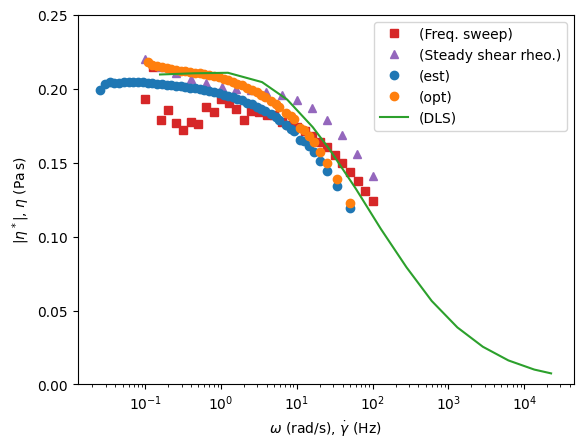

In [22]:
# complex viscosity
eta = G_star / omega
eta_opt = G_star_opt / omega

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# rheology
G_rheo_df['viscosity'] = np.sqrt(G_rheo_df['G_prime']**2 + G_rheo_df['G_second_prime']**2) / G_rheo_df['omega']
ax.plot(G_rheo_df['omega'], G_rheo_df['viscosity'], 'C3s', label="(Freq. sweep)")

# steady shear rheology
ax.plot(rheo_ss_visc_df['gamma_dot'], rheo_ss_visc_df['viscosity'], 'C4^', label="(Steady shear rheo.)")

# estimate
ax.plot(omega, eta, 'C0o', label="(est)")

# optimization
ax.plot(omega, eta_opt, 'C1o', label="(opt)")

# dls
ax.plot(visc_dls_df['omega'], visc_dls_df['viscosity'], 'C2-', label='(DLS)')

ax.set_xscale('log')
ax.set_xlabel(r'$\omega$ (rad/s), $\dot{\gamma}$ (Hz)')
ax.set_ylabel(r"$\vert \eta^* \vert$, $\eta$ (Pa$\,$s)")
ax.set_ylim(0, 0.25)
ax.legend()

fig.savefig('viscosity_cfr.pdf', dpi=600)

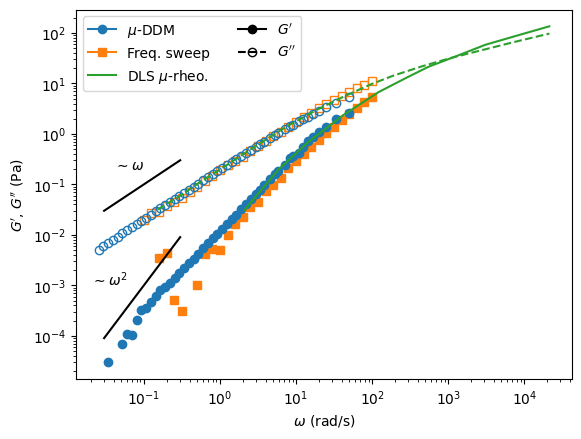

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot frequency sweep data
ax.plot(G_rheo_df['omega'], G_rheo_df['G_prime'], 'C1s')
ax.plot(G_rheo_df['omega'], G_rheo_df['G_second_prime'], 'C1s', markerfacecolor='none')

# estimate
ax.plot(omega, G_prime, 'C0o')
ax.plot(omega, G_secondp, 'C0o', markerfacecolor='none')


# plot also reference lines
x=np.array([3e-2, 3e-1])
ax.plot(x, x, 'k-')
ax.annotate(r'$\sim \omega$', xy=(5e-2, 5e-2), xytext=(4e-2, 2e-1))
ax.plot(x, 1e-1*x**2, 'k-')
ax.annotate(r'$\sim \omega^2$', xy=(5e-2, 3e-4), xytext=(2e-2, 1e-3))

# plot dls data
ax.plot(Gp_dls_df['omega'], Gp_dls_df['Gp'], 'C2-')
ax.plot(Gsp_dls_df['omega'], Gsp_dls_df['Gsp'], 'C2--')

custom_lines = [
    Line2D([0], [0], marker='o', color='C0', label=r'$\mu$-DDM'),
    Line2D([0], [0], marker='s', color='C1', label='Freq. sweep'),
    Line2D([0], [0], linestyle='-', color='C2', label=r'DLS $\mu$-rheo.'),
    Line2D([0], [0], marker='o', linestyle='-', color='k', label=r"$G'$"),
    Line2D([0], [0], marker='o', linestyle='--', markerfacecolor='none', color='k', label=r"$G''$"),
]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$ (rad/s)')
ax.set_ylabel(r"$G'$, $G''$ (Pa)")
ax.legend(handles=custom_lines, ncols=2)

fig.savefig('microrheology_cfr_poster.pdf', dpi=600)

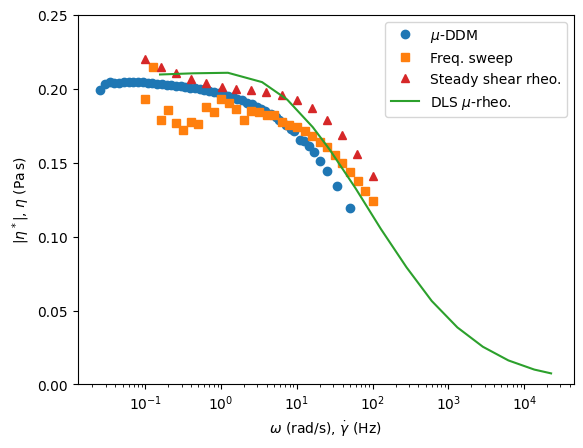

In [24]:
# complex viscosity
eta = G_star / omega
eta_opt = G_star_opt / omega

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# estimate
ax.plot(omega, eta, 'C0o', label=r"$\mu$-DDM")

# rheology
G_rheo_df['viscosity'] = np.sqrt(G_rheo_df['G_prime']**2 + G_rheo_df['G_second_prime']**2) / G_rheo_df['omega']
ax.plot(G_rheo_df['omega'], G_rheo_df['viscosity'], 'C1s', label="Freq. sweep")

# steady shear rheology
ax.plot(rheo_ss_visc_df['gamma_dot'], rheo_ss_visc_df['viscosity'], 'C3^', label="Steady shear rheo.")

# optimization

# dls
ax.plot(visc_dls_df['omega'], visc_dls_df['viscosity'], 'C2-', label=r'DLS $\mu$-rheo.')

ax.set_xscale('log')
ax.set_xlabel(r'$\omega$ (rad/s), $\dot{\gamma}$ (Hz)')
ax.set_ylabel(r"$\vert \eta^* \vert$, $\eta$ (Pa$\,$s)")
ax.set_ylim(0, 0.25)
ax.legend()

fig.savefig('viscosity_cfr_poster.pdf', dpi=600)

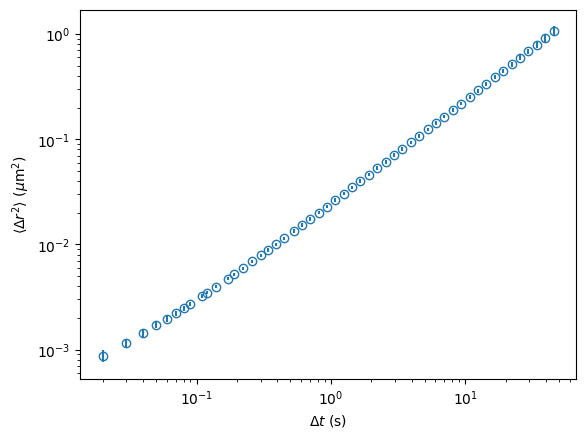

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

ax.errorbar(x=aa_res.tau, y=avg_msd, yerr=std_msd, fmt='o', markerfacecolor='none', label='est')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ ($\mu$m$^2$)')

fig.savefig('msd_cfr_poster.pdf', dpi=600)